In [ ]:
#mounting google drive so we can access files on the google drive since I placed all my data and code on gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# defing path for cracked and non cracked images

In [ ]:
non_cracked_images_path= "/content/drive/MyDrive/FinalProject/dataset/t/0/"
cracked_images_path = "/content/drive/MyDrive/FinalProject/dataset/t/1/"

In [ ]:
# import the necessary packages
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
import progressbar
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import pathlib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam

In [ ]:
import glob #library to get folder details
carcked_images_binay =[] #list to append cracked images 
non_cracked_images_binay = [] #list to append non cracked images

In [ ]:
# glob.glob("/content/drive/MyDrive/courage/dataset (1).zip (Unzipped Files)/dataset/crack_detection_224_images/*.")

#  reading images below and saving in two different list of cracked and uncracked 

In [ ]:
cracked = [f for f in glob.glob(cracked_images_path+"*.png")]
print(len(cracked))

#MA code
non_cracked= [f for f in glob.glob(non_cracked_images_path +"*.png")]
len(non_cracked)

240


83

In [ ]:
IMAGE_DIMS = (224 , 224 , 3)

In [ ]:
#resizing the images to 224x224
def resize_img(mylist,normal):
  for i in mylist:
    image = cv2.imread(i)
    # print(image)

    # resize image if dimensions are different
    if IMAGE_DIMS != image.shape:
        image = resize(image, (IMAGE_DIMS), mode='constant', preserve_range=True)

    # normalize intensity values: [0,1]
    image = image / 255
    normal.append(image)

  return normal

In [ ]:
#calling function to read normal images
resize_img(cracked,carcked_images_binay)

In [ ]:
resize_img(non_cracked,non_cracked_images_binay)

In [ ]:
# Labels=[]

# for f_name in cracked:
#     label=f_name[0]
#     Labels.append(1)
#     print(label)
#     break
  

In [ ]:
# convert list to numpy array for cracked and non-cracked labesl
carcked_images_binay = np.array(carcked_images_binay)
non_cracked_images_binay = np.array(non_cracked_images_binay)

In [ ]:
#cslling function
carcked_images_binay.shape

(240, 224, 224, 3)

In [ ]:
#calling function
non_cracked_images_binay.shape

(83, 224, 224, 3)

In [ ]:
# saving results into list
fi = [carcked_images_binay,non_cracked_images_binay]

In [ ]:
#creating labels DIctinonary
labels = { '0': non_cracked_images_binay,
          '1': carcked_images_binay
          }

In [ ]:
# This data generation is for training dataset
# image_dataset_from_directory(main_directory, labels='inferred') will return a tf.data.Dataset that yields batches of 
# images from the subdirectories class_a and class_b, together with labels 0 and 1 (0 corresponding to class_a and 1 corresponding to class_b).
#


img_height,img_width=224,224
batch_size=32
data_dir = pathlib.Path(r"/content/drive/MyDrive/FinalProject/dataset/t")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 323 files belonging to 2 classes.
Using 259 files for training.


In [ ]:
#getting class names 

classes = train_ds.class_names

In [ ]:
# This data generation is for valoidation dataset
# image_dataset_from_directory(main_directory, labels='inferred') will return a tf.data.Dataset that yields batches of 
# images from the subdirectories class_a and class_b, together with labels 0 and 1 (0 corresponding to class_a and 1 corresponding to class_b).
#
data_dir = pathlib.Path(r"/content/drive/MyDrive/FinalProject/dataset/t")
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 323 files belonging to 2 classes.
Using 64 files for validation.


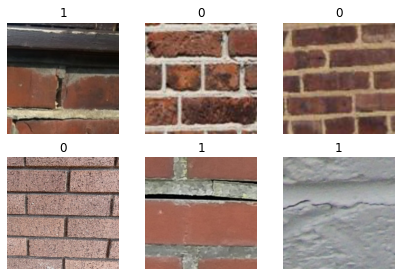

In [ ]:
#plotting random images from dataset with class names
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

In [ ]:
# A preprocessing layer which rescales input values to a new range. since i have two classes I tried to normalize in range of 0 to 1
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
import numpy as np
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.85098046


In [ ]:
#setting data cache size how many images will be stored in cache
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)

In [ ]:
# train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
#defining sequential model
resnet_model = Sequential()
#getting pretrained resnetmodal with imgnet weights
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=2,
                   weights='imagenet')

for layer in pretrained_model.layers:
        layer.trainable=True
# adding resnetlayer to my model
resnet_model.add(pretrained_model)

In [ ]:
#adding flatten layer
resnet_model.add(Flatten())
#adding dense layers
resnet_model.add(Dense(32, activation='relu'))
resnet_model.add(Dense(1, activation='softmax'))

In [ ]:
#plotting summary
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 23,653,313
Trainable params: 23,600,193
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
# compiling model and training
model = resnet_model.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=50)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 15s 556ms/step - loss: 0.0000e+00 - accuracy: 0.7529 - val_loss: 0.0000e+00 - val_accuracy: 0.7031
Epoch 2/50
9/9 [==============================] - 3s 296ms/step - loss: 0.0000e+00 - accuracy: 0.7529 - val_loss: 0.0000e+00 - val_accuracy: 0.7031
Epoch 3/50
9/9 [==============================] - 3s 298ms/step - loss: 0.0000e+00 - accuracy: 0.7529 - val_loss: 0.0000e+00 - val_accuracy: 0.7031
Epoch 4/50
9/9 [==============================] - 3s 299ms/step - loss: 0.0000e+00 - accuracy: 0.7529 - val_loss: 0.0000e+00 - val_accuracy: 0.7031
Epoch 5/50
9/9 [==============================] - 3s 300ms/step - loss: 0.0000e+00 - accuracy: 0.7529 - val_loss: 0.0000e+00 - val_accuracy: 0.7031
Epoch 6/50
9/9 [==============================] - 3s 300ms/step - loss: 0.0000e+00 - accuracy: 0.7529 - val_loss: 0.0000e+00 - val_accuracy: 0.7031
Epoch 7/50
9/9 [==============================] - 3s 301ms/step - loss: 0.0000e+00 - accuracy: 0.7529 - val_loss: 0.0000e+

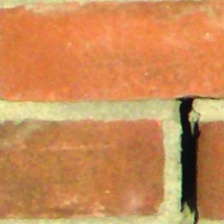

In [ ]:
#ploting predicted images
import cv2
import numpy as np
# imagenet
from google.colab.patches import cv2_imshow
image=cv2.imread(r"/content/drive/MyDrive/FinalProject/dataset/t/1/a_0_10.png")
cv2_imshow(image)
# cv2.waitKey(0)
image_resized= cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)

In [ ]:
# prediciton
pred=resnet_model.predict(image)

In [ ]:
pred=resnet_model.predict(val_ds)

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


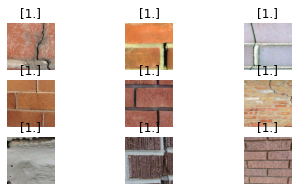

In [ ]:
# class_names = val_ds.class_names


#plotting predicted classes
for images , labels in val_ds.take(3):
  for i in range(9):
    ax = plt.subplot(4,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(pred[labels[i]])
    # plt.
    plt.axis('off')

In [ ]:
# output_class=class_names[np.argmax(pred)]
print("The predicted class is", int(pred[0]))

The predicted class is 1


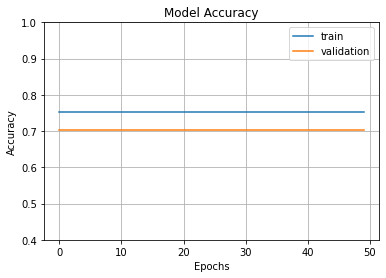

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

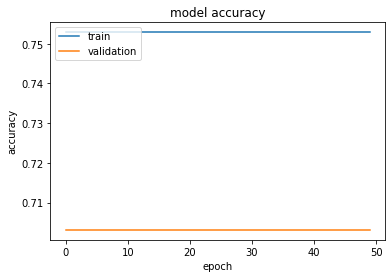

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [ ]:

# The reason for straight accuracy line is that the model is not able to learn in 10 epochs.
#  Because different features do not have similar ranges of values and hence gradients may 
#  end up taking a long time and can oscillate back and forth and take a long time before it 
 

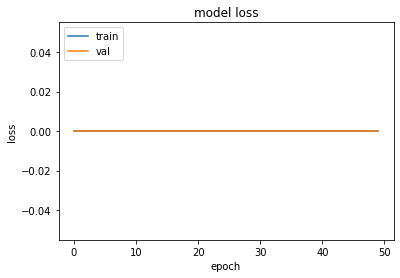

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

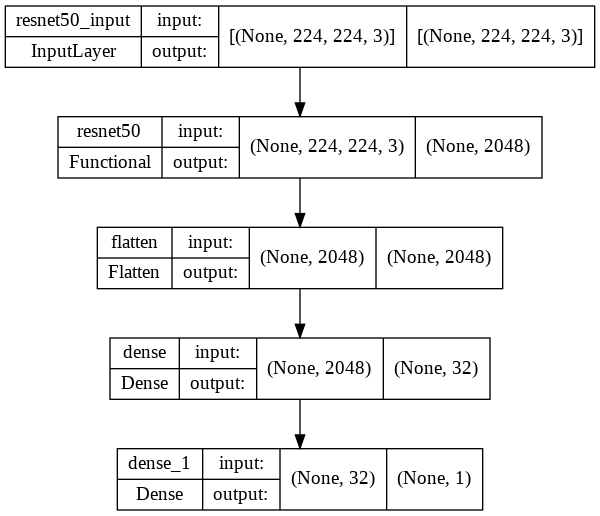

In [ ]:

from keras.utils.vis_utils import plot_model

plot_model(resnet_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)